In [57]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
import pandas as pd

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> State update </h1>

In [59]:
def update_state(c,b,g_0,omega_tab,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k1, 1_k2, 0>
    b (np array): Atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix = 1j * g_0 * np.sqrt(omega_A / L) * np.exp(-1j * (omega_tab - omega_A) * t)

    b_new = 2 * g_matrix @ c
    c_new = 0.5 * (b[:, np.newaxis] * np.conjugate(g_matrix)[np.newaxis, :] + np.conjugate(g_matrix)[:, np.newaxis] * b[np.newaxis, :])

    return -1j* dt * c_new, -1j * dt * b_new

<h1> RG Scheme </h1>

In [60]:
def RG_scheme(c_init, b_init, g_0, omega_tab, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k1, 1_k2, 0>
    b_init (np array): initial atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(c_init)
    c_array = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
    b_array = np.zeros((nb_pts_time, n_modes), dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b_array[0] = b_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b_current = b_array[i-1]

        c_new_k1, b_new_k1 = update_state(c_current, b_current, g_0, omega_tab, omega_A, L, t, dt)
        c_new_k2, b_new_k2 = update_state(c_current + c_new_k1/2, b_current + b_new_k1/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k3, b_new_k3 = update_state(c_current + c_new_k2/2, b_current + b_new_k2/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k4, b_new_k4 = update_state(c_current + c_new_k3, b_current + b_new_k3, g_0, omega_tab, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b_new = b_current + (b_new_k1 + 2*b_new_k2 + 2*b_new_k3 + b_new_k4) / 6

        c_array[i] = c_new
        b_array[i] = b_new

    return c_array, b_array 
    

<h1> Function that treats the whole evolution </h1>

In [61]:
def get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = False, progress_bar=True):
    """
    Generate data for the RG scheme with a beamsplitter.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the first Gaussian peak.
    x_1 (float): Position of the second Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k1, 1_k2, 0>.
    b_array (np array): Coefficients in front of the state |1_k, 1>.
    omega_tab (np array): Array of frequencies.
    """
    
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(omega_tab)

    if print_info:
        print("Number of modes: ", n_modes)
        
    
    #prepare the initial state
    if print_info:
        print("Preparing the initial state...")
    c_init = np.zeros((n_modes, n_modes), dtype=complex)
    b_init = np.zeros(n_modes, dtype=complex)

    c_init_photon_1 = np.exp(-(0.5*(k_tab - omega_0)**2) * sigma**2) * np.exp(-1j * k_tab * x_0)
    c_init_photon_2 = np.exp(-(0.5*(k_tab + omega_0)**2) * sigma**2) * np.exp(-1j * k_tab * x_1)

    #make photons indistinguishable
    c_init = 0.5 * (c_init_photon_1[:, np.newaxis] * c_init_photon_2[np.newaxis, :] + c_init_photon_2[:, np.newaxis] * c_init_photon_1[np.newaxis, :]) #symmetrize the stat
    c_init /= np.sqrt(np.sum(np.abs(c_init)**2)) #normalize the state
    
    ##evolve the state
    if print_info:
        print("Evolving the state...")
    c_array, b_array = RG_scheme(c_init, b_init, g_0, omega_tab, omega_A, L, T, dt, progress_bar=progress_bar)

    ##compute the overlap with the initial state
    if print_info:
        print("Computing the overlap with the initial state...")
    overlap_tab = np.zeros(int(T / dt), dtype=complex)

    for i in tqdm(range(int(T / dt))):
        c_current = c_array[i]
        b_current = b_array[i]
        overlap_tab[i] = np.abs(np.sum(np.conjugate(c_init) * c_current))**2 + np.abs(np.conjugate(b_init) @ b_current)**2

    return c_array, b_array, overlap_tab

<h1> First test </h1>

In [88]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 10
omega_A = 1
gamma = 2*g_0**2*omega_A

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4
x_1 = L/4 - L/8 
omega_0 = 2

#numerical implementation of momentum space
omega_max = 10

c_array, b_array, overlap_tab = get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = True, progress_bar=True)

Number of modes:  101
Preparing the initial state...
Evolving the state...


  0%|          | 0/1569 [00:00<?, ?it/s]

Computing the overlap with the initial state...


  0%|          | 0/1570 [00:00<?, ?it/s]

<h1> Coherence and atom excitation </h1>

In [89]:
time_array = np.linspace(0, T, int(T / dt))

nb_pts_time = int(T / dt)
atom_excitation = np.zeros(nb_pts_time)
coherence = np.zeros(nb_pts_time)

#get the number of modes
n_modes = c_array[0].shape[0] // 2

for i in tqdm(range(nb_pts_time)):
    c_current, b_current = c_array[i], b_array[i]
    atom_excitation[i] = np.sum(np.abs(b_current)**2)
    #for a in range(n_modes):
    #    for b in range(n_modes):
    #        coherence[i] += np.abs( c_current[a, n_modes + b] * np.conjugate(c_current[a, n_modes + b])) + np.abs( c_current[n_modes + a, b] * np.conjugate(c_current[n_modes + a, b]))

  0%|          | 0/1570 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


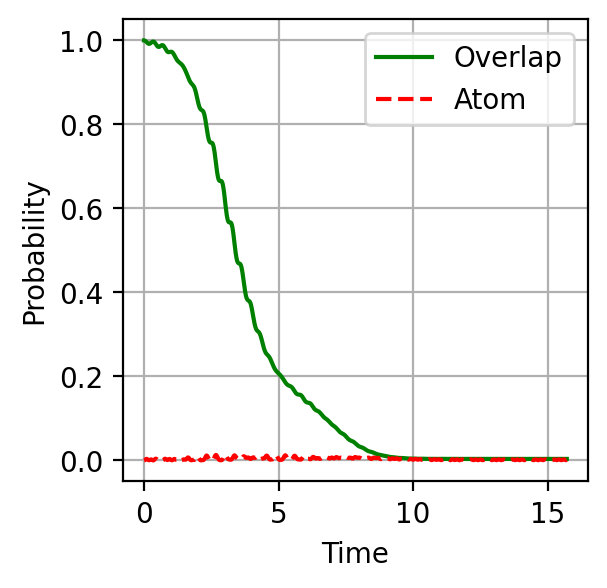

In [90]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(time_array, overlap_tab, label='Overlap', color='green')
#ax.plot(time_array, coherence,label='Coherence', linestyle='-', color='blue', alpha=0.5)
ax.plot(time_array, atom_excitation,label='Atom', linestyle='--', color='red')
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()

<h1> Reproduce a HOM effect </h1>

In [55]:
#Lenght of the system and time parameters
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 2
omega_A = 1
gamma = 2*g_0**2*omega_A

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
omega_0 = 2

#numerical implementation of momentum space
omega_max = 15

nb_pts_x = 7
overlap_final_tab = np.zeros(nb_pts_x)
x_0 = -L/4

for i, delta_x in enumerate(np.linspace(-L/8, L/8, nb_pts_x)):
    x_1 = L/4 + delta_x
    print(f"Running for x_1 = {x_1:.2f}")
    c_array, b_array, overlap_tab = get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = False, progress_bar=False)
    overlap_final_tab[i] = overlap_tab[-1]

Running for x_1 = 3.93


  0%|          | 0/1570 [00:00<?, ?it/s]

/var/folders/ds/7w970h197d59hh_2dj4ry5qw0000gn/T/ipykernel_3398/2140400323.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_final_tab[i] = overlap_tab[-1]


Running for x_1 = 5.24


  0%|          | 0/1570 [00:00<?, ?it/s]

Running for x_1 = 6.54


  0%|          | 0/1570 [00:00<?, ?it/s]

Running for x_1 = 7.85


  0%|          | 0/1570 [00:00<?, ?it/s]

Running for x_1 = 9.16


  0%|          | 0/1570 [00:00<?, ?it/s]

Running for x_1 = 10.47


  0%|          | 0/1570 [00:00<?, ?it/s]

Running for x_1 = 11.78


  0%|          | 0/1570 [00:00<?, ?it/s]

Now check the results

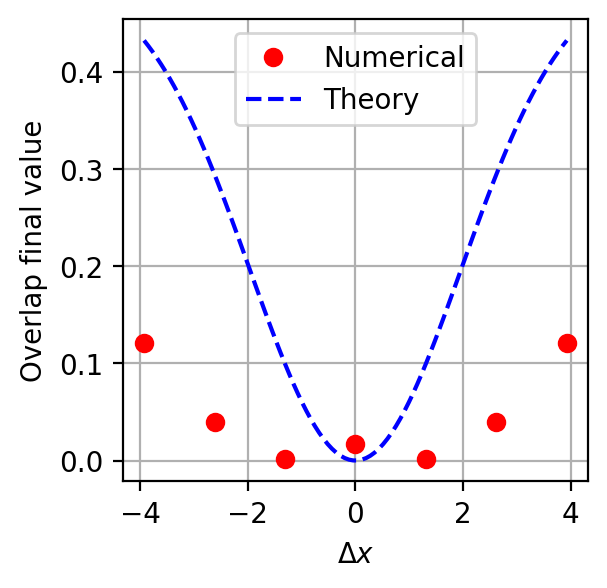

In [56]:
theory_delta_x = np.linspace(-L/8, L/8, 100)
theory_curve = 0.5 * (1 - np.exp(-0.5 * (theory_delta_x / sigma)**2))

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(np.linspace(-L/8, L/8, nb_pts_x), overlap_final_tab, marker='o', linestyle='', label='Numerical', color='red')
ax.plot(theory_delta_x, theory_curve, label='Theory', color='blue', linestyle='--')
ax.set_xlabel(r'$\Delta x$')
ax.set_ylabel('Overlap final value')
ax.legend()
ax.grid()
plt.show()



<h1> Wave function checks </h1>

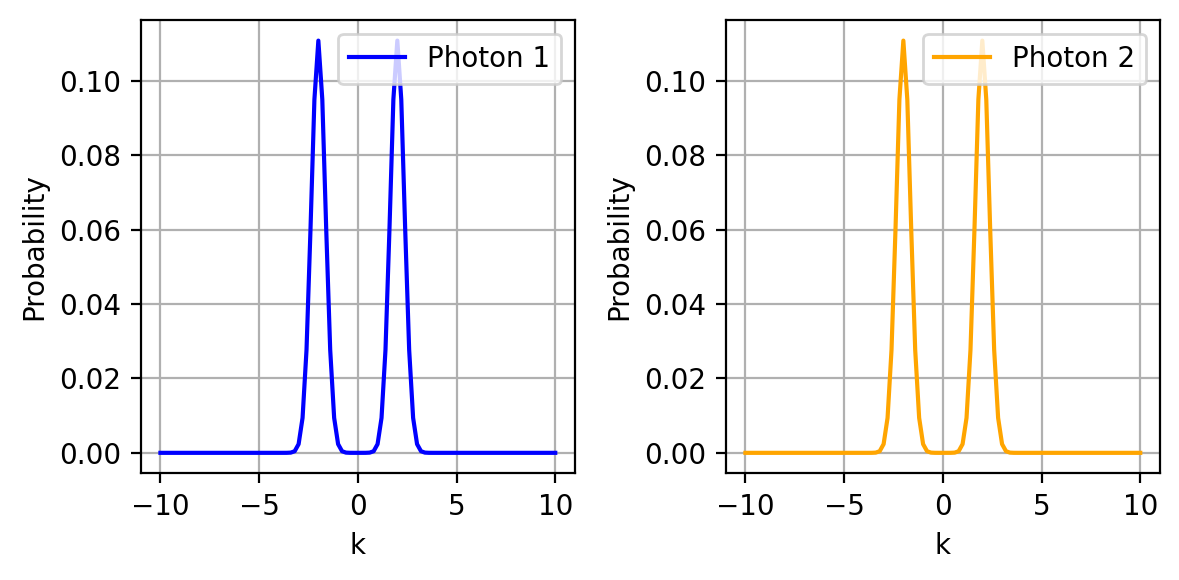

In [91]:
## First, check the wave function in momentum space for the first photon
c_init = c_array[0]

#quantization of the modes
omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
omega_tab = np.abs(k_tab)
n_modes = len(omega_tab)


c_photon_1_momentum = np.zeros(n_modes)
c_photon_2_momentum = np.zeros(n_modes)

for i in range(n_modes):
    c_photon_1_momentum[i] += np.sum(np.abs(c_init[i, :])**2)
    c_photon_2_momentum[i] += np.sum(np.abs(c_init[:, i])**2)

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=resol)
ax[0].plot(k_tab, c_photon_1_momentum, label='Photon 1', color='blue')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].grid()

ax[1].plot(k_tab, c_photon_2_momentum, label='Photon 2', color='orange')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Probability')
ax[1].legend()
ax[1].grid()

fig.tight_layout()
plt.show()